# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [1]:
# Install dependencies
!pip install -U sentence-transformers #latest version
!pip install datasets
!pip install faiss-cpu
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Import libraries
import json
import torch
import random
import numpy as np
import faiss
import os
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util, InputExample, losses, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
from graphviz import Digraph

# Enable GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Disable wandb login
os.environ["WANDB_DISABLED"] = "true"

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
# Clone Git repository and mount Drives
!git clone https://github.com/drcarenhan/COMP90042_2025
from google.colab import drive
drive.mount('/content/drive')

fatal: destination path 'COMP90042_2025' already exists and is not an empty directory.
Mounted at /content/drive


In [5]:
# Load datasets
with open('COMP90042_2025/data/train-claims.json', 'r') as f:
    train_claims = json.load(f)

with open('COMP90042_2025/data/dev-claims.json', 'r') as f:
    dev_claims = json.load(f)

with open('/content/drive/MyDrive/evidence.json', 'r') as f:  # replace with path to evidence.json file
    evidences = json.load(f)

In [6]:
# Inspect the length of evidences
evidence_ids = list(evidences.keys())
evidence_texts = [evidences[eid] for eid in evidence_ids]

# Compute sentence lengths
lengths = [len(text.split()) for text in evidence_texts]

# Compute and round descriptive stats
length_stats = pd.Series(lengths).describe().round(0).astype(int)
print(length_stats)

count    1208827
mean          20
std           10
min            1
25%           12
50%           18
75%           25
max          479
dtype: int64


In [7]:
'''This function preprocesses given text by decoding Unicode escapes, cleanup whitespace
and remove empty strings or too short evidences. Return the given text that has been cleaned'''
def clean_filter_text(text, text_type):
    min_words = 10
    try:
        # Decode Unicode escapes (e.g., \u00f1 → ñ)
        decoded = text.encode('utf-8').decode('unicode_escape')

        # Whitespace cleanup: strip and normalize internal spaces
        cleaned = ' '.join(decoded.strip().split())

        # Remove if string is empty
        if not cleaned:
            return None

        # Remove too short evidence
        if text_type == 'evidence' and len(cleaned.split()) < min_words:
            return None
        return cleaned
    except UnicodeDecodeError:
        return None  # Skip if decoding fails

def preprocess_claims(claims):
  '''This function uses the clean_filter_text to preprocess text in the given
  set of claims, keeping the claim label and evidences id unchanged
  Return the processed claims in a dictionary'''
  processed_claims = {}
  for claim_id, claim in claims.items():
      cleaned_text = clean_filter_text(claim['claim_text'], text_type='claim')
      if cleaned_text:  # remove instance if it is empty
          processed_claims[claim_id] = {
              'claim_text': cleaned_text,
              'claim_label': claim['claim_label'],
              'evidences': claim['evidences']
          }
  return processed_claims

# Preprocess training claims and development claims
processed_train_claims = preprocess_claims(train_claims)
processed_dev_claims = preprocess_claims(dev_claims)

# Process each evidence entry
processed_evidences = {}

for evidence_id, text in evidences.items():
    cleaned = clean_filter_text(text, text_type='evidence')
    if cleaned:
        processed_evidences[evidence_id] = cleaned

<ipython-input-7-28e2f25fc08a>:7: DeprecationWarning: invalid escape sequence '\ '
  decoded = text.encode('utf-8').decode('unicode_escape')
<ipython-input-7-28e2f25fc08a>:7: DeprecationWarning: invalid escape sequence '\d'
  decoded = text.encode('utf-8').decode('unicode_escape')
<ipython-input-7-28e2f25fc08a>:7: DeprecationWarning: invalid escape sequence '\c'
  decoded = text.encode('utf-8').decode('unicode_escape')
<ipython-input-7-28e2f25fc08a>:7: DeprecationWarning: invalid escape sequence '\.'
  decoded = text.encode('utf-8').decode('unicode_escape')
<ipython-input-7-28e2f25fc08a>:7: DeprecationWarning: invalid escape sequence '\)'
  decoded = text.encode('utf-8').decode('unicode_escape')


In [8]:
# Dataset after preprocessing
print(f"Original number of evidences: {len(evidences)}")
print(f"Filtered number of evidences: {len(processed_evidences)}")
print(f"Evidences removed: {len(evidences) - len(processed_evidences)}\n")

print(f"Original number of training claims: {len(train_claims)}")
print(f"Filtered number of training claims: {len(processed_train_claims)}")
print(f"Training claims removed: {len(train_claims) - len(processed_train_claims)}\n")

print(f"Original number of development claims: {len(dev_claims)}")
print(f"Filtered number of development claims: {len(processed_dev_claims)}")
print(f"Development claims removed: {len(dev_claims) - len(processed_dev_claims)}")

Original number of evidences: 1208827
Filtered number of evidences: 1066489
Evidences removed: 142338

Original number of training claims: 1228
Filtered number of training claims: 1228
Training claims removed: 0

Original number of development claims: 154
Filtered number of development claims: 154
Development claims removed: 0


In [9]:
# Filter training claims to keep only those with at least one valid evidence
filtered_train_claims = {}

for claim_id, claim_data in processed_train_claims.items():
    # Filter evidences that still exist
    valid_evidences = [eid for eid in claim_data["evidences"] if eid in processed_evidences]

    if valid_evidences:
        # Only include the claim if there's at least one valid evidence
        filtered_train_claims[claim_id] = {
            **claim_data,
            "evidences": valid_evidences
        }
# Prepare list of evidence texts
evidence_texts = list(processed_evidences.values())

# Prepare list development claim texts
dev_claim_ids = list(processed_dev_claims.keys())
dev_claim_texts = [processed_dev_claims[cid]["claim_text"] for cid in dev_claim_ids]

# Build all claim-evidence pairs for Sentence-BERT
all_pairs = []
for claim in filtered_train_claims.values():
    claim_text = claim["claim_text"]
    for evidence_id in claim["evidences"]:
        if evidence_id in processed_evidences:
            evidence_text = processed_evidences[evidence_id]
            if claim_text and evidence_text:
                all_pairs.append((claim_text, evidence_text))

# Split into train and validation for hyper-parameter tuning
train_pairs, val_pairs = train_test_split(all_pairs, test_size=0.1, random_state=42)
train_examples = [InputExample(texts=[claim, evidence]) for claim, evidence in train_pairs]

# All examples to use for actual training
all_examples = [InputExample(texts=[claim, evidence]) for claim, evidence in all_pairs]

In [10]:
# Count how many texts exceed 256 words
claim_exceed = sum(len(text.split()) > 256 for text in dev_claim_texts)
evidence_exceed = sum(len(text.split()) > 256 for text in evidence_texts)
print(f"Number of dev claims exceeding 256 words: {claim_exceed}")
print(f"Number of evidences exceeding 256 words: {evidence_exceed}")

Number of dev claims exceeding 256 words: 0
Number of evidences exceeding 256 words: 3


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

# Evidence Retrieval

In [12]:
# THIS CODE IS TO CREATE THE DIAGRAM OF PIPELINE IN THE REPORT
dot = Digraph()
dot.attr(rankdir='BT')
dot.attr(nodesep='0.1')  # space between nodes on same rank
dot.attr(ranksep='0.2')  # space between ranks

# Nodes for inputs
dot.node('C', 'Claim', shape='box')
dot.node('E', 'Evidence', shape='box')

# BERT nodes
dot.node('B1', 'BERT', shape='box')
dot.node('B2', 'BERT', shape='box')

# Pooling nodes
dot.node('P1', 'mean pooling', shape='box')
dot.node('P2', 'mean pooling', shape='box')

# Embeddings
dot.node('EC', '384-dim embedding c', shape='box')
dot.node('EE', '384-dim embedding e', shape='box')

# Cosine similarity
dot.node('S', 'cosine-sim(c,e)', shape='box')

# Loss computation
dot.node('L', 'Loss function (MultipleNegativesRankingLoss)', shape='box')

# Connections
dot.edge('C', 'B1', minlen='1')
dot.edge('E', 'B2', minlen='1')
dot.edge('B1', 'P1', minlen='1')
dot.edge('B2', 'P2', minlen='1')
dot.edge('P1', 'EC', minlen='1')
dot.edge('P2', 'EE', minlen='1')
dot.edge('EC', 'S', minlen='1')
dot.edge('EE', 'S', minlen='1')
dot.edge('S', 'L', minlen='1')

dot.render('sbert_pipeline', format='png', view=True) # output the diagram in sbert_pipeline.png

'sbert_pipeline.png'

### Hyper-parameter tuning:
In this section we will fine-tune the number of epochs to train for the Sentence-BERT model using the evaluation metric Recall@1 and MRR. Then we will find the best similarity score threshold for retrieving relevant evidence, based on evaluation metric F1.

In [10]:
def evaluate_retrieval(model, val_pairs):
    """
    This function uses the model input to find the relevant evidences for each claim
    in the validation set, then print out evaluation metric Recall@1 and MRR
    of the predictions
    """
    claim_texts = [claim for claim, _ in val_pairs]
    gold_evidences = [evidence for _, evidence in val_pairs]

    # Create a candidate pool (just the unique evidence texts from val)
    unique_evidences = list(set(gold_evidences))

    # Encode all claims and evidence
    claim_embeddings = model.encode(claim_texts, convert_to_tensor=True)
    evidence_embeddings = model.encode(unique_evidences, convert_to_tensor=True)

    # Compute cosine similarity
    scores = util.cos_sim(claim_embeddings, evidence_embeddings)

    recall_at_1 = 0
    reciprocal_ranks = []

    for i, claim in enumerate(claim_texts):
        gold = gold_evidences[i]
        ranked_indices = scores[i].cpu().numpy().argsort()[::-1]
        ranked_evidence = [unique_evidences[idx] for idx in ranked_indices]

        # Recall@1
        if ranked_evidence[0] == gold:
            recall_at_1 += 1

        # MRR
        for rank, candidate in enumerate(ranked_evidence):
            if candidate == gold:
                reciprocal_ranks.append(1 / (rank + 1))
                break
        else:
            reciprocal_ranks.append(0)

    recall_at_1 /= len(claim_texts)
    mrr = np.mean(reciprocal_ranks)

    return recall_at_1, mrr

In [13]:
# Prepare model and data
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
train_loss = losses.MultipleNegativesRankingLoss(model)

# Maximum number of epochs to train over
max_epochs = 6

# Create training loop
recall_at_1_values = []
mrr_values = []

for epoch in range(max_epochs):
    print(f"Epoch = {epoch+1}")
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=epoch+1,
        show_progress_bar=True
    )
    recall_at_1, mrr = evaluate_retrieval(model, val_pairs)
    print(f"Epoch {epoch+1}: Recall@1 = {recall_at_1:.4f}, MRR = {mrr:.4f}")

    # Store the results for plotting
    recall_at_1_values.append(recall_at_1)
    mrr_values.append(mrr)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch = 1


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 1: Recall@1 = 0.2374, MRR = 0.3621
Epoch = 2


Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 2: Recall@1 = 0.2551, MRR = 0.3802
Epoch = 3


Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 3: Recall@1 = 0.2778, MRR = 0.4138
Epoch = 4


Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 4: Recall@1 = 0.3030, MRR = 0.4472
Epoch = 5


Step,Training Loss
500,0.926200


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch 5: Recall@1 = 0.3081, MRR = 0.4647
Epoch = 6


Step,Training Loss
500,0.836400


Epoch 6: Recall@1 = 0.3157, MRR = 0.4793


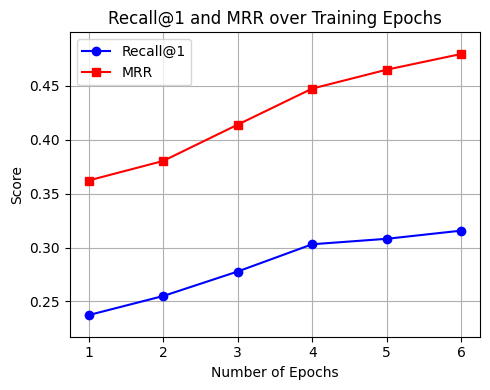

In [14]:
# Define epochs to plot
x_range = range(1, max_epochs + 1)

# Find the appropriate y range
all_scores = recall_at_1_values + mrr_values
y_min = max(min(all_scores) - 0.02, 0)
y_max = min(max(all_scores) + 0.02, 1)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_range, recall_at_1_values, label='Recall@1', color='blue', marker='o')
plt.plot(x_range, mrr_values, label='MRR', color='red', marker='s')

plt.xlabel('Number of Epochs')
plt.ylabel('Score')
plt.title('Recall@1 and MRR over Training Epochs')
plt.ylim(y_min, y_max)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Start finding the best threshold

def evaluate_thresholds(cosine_scores, claims, evidences, gold_pairs, thresholds):
    """
    Computes precision, recall, and F1 score for various cosine similarity thresholds.

    Args:
        cosine_scores: Tensor [num_claims x num_evidences], similarity scores.
        claims: List of claim strings.
        evidences: List of evidence strings.
        gold_pairs: Set of (claim, evidence) tuples that are ground-truth matches.
        thresholds: Thresholds to evaluate.

    Returns:
        best_threshold: Threshold with highest F1 score.
        results: List of tuples (threshold, precision, recall, f1).
    """
    gold_set = set(gold_pairs)
    num_claims = len(claims)
    num_evidences = len(evidences)
    results = []

    # Pre-build a mapping from index to string for efficiency
    claim_lookup = {i: claim for i, claim in enumerate(claims)}
    evidence_lookup = {j: evidence for j, evidence in enumerate(evidences)}

    best_f1 = -1
    best_threshold = None

    for threshold in thresholds:
        retrieved = cosine_scores >= threshold  # binary mask to retrieve
                                                #only evidence with score above threshold

        y_true = []
        y_pred = []

        # Get the ground truth and predicted evidences with score above threshold
        for i in range(num_claims):
            for j in torch.where(retrieved[i])[0]:
                pair = (claim_lookup[i], evidence_lookup[j.item()])
                is_gold = pair in gold_set
                y_true.append(1 if is_gold else 0)
                y_pred.append(1)

        # Add false negatives: gold pairs that were not retrieved
        for pair in gold_set:
            c, e = pair
            if c in claim_lookup.values() and e in evidence_lookup.values():
                i = claims.index(c)
                j = evidences.index(e)
                if cosine_scores[i][j] < threshold:
                    y_true.append(1)
                    y_pred.append(0)

        # Calculate precision, recall and F1
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        # Store results
        results.append((threshold, precision, recall, f1))

        # Check for highest F1
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Print results
    for t, p, r, f in results:
        print(f"Threshold {t:.2f}: Precision={p:.4f}, Recall={r:.4f}, F1={f:.4f}")
    print(f"\n Best threshold: {best_threshold:.2f} with F1: {best_f1:.4f}")

    return best_threshold, results

In [16]:
# Load pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Prepare the DataLoader for training
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

# Loss function: MultipleNegativeRankingLoss
train_loss = losses.MultipleNegativesRankingLoss(model)

# Train the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=4, # use the optimal epoch found earlier
    show_progress_bar=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


In [17]:
# Encode claims and evidences using the trained model
val_claim_texts = [claim for claim, _ in val_pairs]
claim_embeddings = model.encode(val_claim_texts, convert_to_tensor=True)
evidence_embeddings = model.encode(evidence_texts, convert_to_tensor=True,
                                   device=device, show_progress_bar=True, batch_size=32)
# Build the cosine similarity matrix
cosine_scores = util.cos_sim(claim_embeddings, evidence_embeddings)

Batches:   0%|          | 0/33328 [00:00<?, ?it/s]

In [18]:
thresholds = np.arange(0.5, 0.91, 0.1)

#Run threshold search
best_threshold, results = evaluate_thresholds(cosine_scores, val_claim_texts,
                                      evidence_texts, val_pairs, thresholds)

Threshold 0.50: Precision=0.0119, Recall=0.4523, F1=0.0232
Threshold 0.60: Precision=0.0427, Recall=0.2019, F1=0.0706
Threshold 0.70: Precision=0.0708, Recall=0.0377, F1=0.0492
Threshold 0.80: Precision=0.3333, Recall=0.0076, F1=0.0148
Threshold 0.90: Precision=0.0000, Recall=0.0000, F1=0.0000

 Best threshold: 0.60 with F1: 0.0706


### Fine tune on whole training data set:
In this section we train Sentence-BERT on all training claim-evidence pairs available using the optimal number of epochs found

In [47]:
# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Prepare the DataLoader for training on all examples
train_dataloader = DataLoader(all_examples, shuffle=True, batch_size=32)

# Loss function: MultipleNegativeRankingLoss
train_loss = losses.MultipleNegativesRankingLoss(model)

model.to(device)

# Train the model on all examples
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=4,
    show_progress_bar=True
)
# Save the model after training
model.save("fine_tuned_sbert")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


# Classification

## Frozen Encoder

In [48]:
# Required Libraries
import torch
from sentence_transformers import SentenceTransformer

# Assuming the processed_train_claims and processed_evidences are already defined in the notebook context

def construct_inputs_for_encoder(claims, evidences):
    """
    Construct combined inputs for the encoder by concatenating claim and evidence passages.

    Args:
    - claims (dict): The processed claims data.
    - evidences (dict): The processed evidence data.

    Returns:
    - combined_inputs (dict): A dictionary with claim_id as key and a dictionary with
                              "input_text" and "label" as values.
    """
    combined_inputs = {}

    for claim_id, claim_data in claims.items():
        claim_text = claim_data['claim_text']
        claim_label = claim_data['claim_label']
        evidence_ids = claim_data['evidences']

        # Retrieve evidence passages
        evidence_texts = [evidences[e_id] for e_id in evidence_ids if e_id in evidences]

        # Combine into a single input string
        combined_text = "[CLS] " + claim_text + " [SEP] " + " [SEP] ".join(evidence_texts) + " [SEP]"

        # Store in dictionary
        combined_inputs[claim_id] = {
            "input_text": combined_text,
            "label": claim_label
        }

    return combined_inputs

# Constructing inputs for training data
combined_train_inputs = construct_inputs_for_encoder(processed_train_claims, processed_evidences)
combined_dev_inputs = construct_inputs_for_encoder(processed_dev_claims, processed_evidences)

# Displaying the first 2 entries to verify the structure
for idx, (claim_id, data) in enumerate(combined_train_inputs.items()):
    print(f"Claim ID: {claim_id}")
    print(f"Input Text: {data['input_text']}")
    print(f"Label: {data['label']}")
    print("=" * 80)
    if idx == 1:  # Display only the first 2 for brevity
        break

# ---------------------------------------------------------------------

# Encoding with Frozen Encoder

# Load the frozen encoder
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
encoder = SentenceTransformer(model_name)


# Define the label mapping
LABEL_MAP = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT_ENOUGH_INFO": 2,
    "DISPUTED": 3
}


def encode_inputs(combined_inputs, encoder):
    # """
    # Encode the input texts using the frozen encoder.

    # Args:
    # - combined_inputs (dict): The constructed input dictionary.
    # - encoder: The frozen encoder model.

    # Returns:
    # - encoded_outputs (dict): Dictionary with claim_id as key and the embedding tensor as value.
    # """

    """
    Encode the input texts using the frozen encoder and include claim_id.

    Args:
    - combined_inputs (dict): The constructed input dictionary.
    - encoder: The frozen encoder model.

    Returns:
    - encoded_outputs (list): A list of dictionaries with "claim_id", "embedding", and "label".
    """
    encoded_outputs = []

    for claim_id, data in combined_inputs.items():
        input_text = data["input_text"]
        label = data["label"]

        # processed_data["labels"] = torch.tensor([['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO', 'DISPUTED'].index(label) for label in processed_data["labels"]])


        # Encode the input text
        embedding = encoder.encode(input_text, convert_to_tensor=True).cpu()

        # Encode label as integer
        label_id = LABEL_MAP[label]

        # Store the claim_id, embedding, and label
        encoded_outputs.append({
            "claim_id": claim_id,
            "embedding": embedding,
            "label": label_id
        })

    return encoded_outputs


# Encoding the constructed inputs
encoded_train_inputs = encode_inputs(combined_train_inputs, encoder)
encoded_dev_inputs = encode_inputs(combined_dev_inputs, encoder)

Claim ID: claim-1937
Input Text: [CLS] Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life. [SEP] At very high concentrations (100 times atmospheric concentration, or greater), carbon dioxide can be toxic to animal life, so raising the concentration to 10,000 ppm (1%) or higher for several hours will eliminate pests such as whiteflies and spider mites in a greenhouse. [SEP] Plants can grow as much as 50 percent faster in concentrations of 1,000 ppm CO 2 when compared with ambient conditions, though this assumes no change in climate and no limitation on other nutrients. [SEP] Higher carbon dioxide concentrations will favourably affect plant growth and demand for water. [SEP]
Label: DISPUTED
Claim ID: claim-126
Input Text: [CLS] El NiÃ±o drove record highs in global temperatures suggesting rise may not be down to man-made emissions. [SEP] While âclimate changeâ can be due to natural fo

In [49]:
# Displaying the first encoded outputs to verify structure and embedding size

for claim in encoded_train_inputs:
  print(f"Claim ID: {claim['claim_id']}")
  print(f"Embedding Shape: {claim['embedding'].shape}")
  print(f'Label: {claim["label"]}')
  # print(claim)
  break

Claim ID: claim-1937
Embedding Shape: torch.Size([384])
Label: 3


## Custom Transformer

In [50]:
import torch
import torch.nn as nn

class CustomTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, num_layers, num_classes, dropout):
        super(CustomTransformer, self).__init__()

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )

        # Transformer Encoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, inputs_embeds, labels=None):
        """
        Args:
        - inputs_embeds: Tensor of shape (batch_size, seq_len, input_dim)
        - labels: Tensor of shape (batch_size,)

        Returns:
        - Output dictionary containing logits and optionally loss.
        """
        # Transformer Encoder
        encoded_output = self.encoder(inputs_embeds)  # (batch_size, seq_len, input_dim)

        # Use CLS token (first token) as the representative embedding
        cls_token_output = encoded_output[:, 0, :]

        # Classification Head
        logits = self.classifier(cls_token_output)

        output = {"logits": logits}

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            output["loss"] = loss

        return output

# Define model parameters
input_dim = 384
num_heads = 8
hidden_dim = 256
num_layers = 2
num_classes = 4
dropout = 0.2

# Initialize the custom transformer model
transformer_model = CustomTransformer(input_dim, num_heads, hidden_dim, num_layers, num_classes, dropout)

In [51]:
from torch.utils.data import Dataset

class EmbeddingDataset(Dataset):
    def __init__(self, encoded_data):
        self.data = encoded_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Ensure the input is in the shape (seq_len, input_dim)
        embedding_sequence = sample["embedding"].unsqueeze(0)  # Add seq_len dimension
        return {
            "inputs_embeds": embedding_sequence,
            "labels": sample["label"]
        }

# Initialize dataset
train_dataset = EmbeddingDataset(encoded_train_inputs)
eval_dataset = EmbeddingDataset(encoded_dev_inputs)

In [52]:
def custom_data_collator(features):
    """
    Collates the list of samples into a batch tensor using "inputs_embeds" and "labels".
    """
    inputs_embeds = torch.stack([f["inputs_embeds"] for f in features])  # (batch_size, seq_len, input_dim)
    labels = torch.tensor([f["labels"] for f in features])               # (batch_size,)

    return {"inputs_embeds": inputs_embeds, "labels": labels}


In [53]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    """
    Compute accuracy and F1 score.
    Args:
        eval_pred: A tuple of (logits, labels).
    Returns:
        A dictionary with accuracy and F1 score.
    """
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)  # Get predicted class indices

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')

    return {
        "accuracy": accuracy,
        "f1": f1
    }

In [54]:
from transformers import TrainingArguments, Trainer

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="transformer_trainer",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=10,
    eval_strategy="epoch"
)

# Initialize Trainer
trainer_transformer = Trainer(
    model=transformer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_data_collator,
    compute_metrics=compute_metrics
)

# Start Training
trainer_transformer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.230900,1.103522,0.571429,0.450441
2,1.171400,1.099651,0.564935,0.478214
3,1.056800,1.116889,0.538961,0.471507
4,0.979700,1.127514,0.532468,0.472684
5,0.922700,1.134704,0.525974,0.467794


TrainOutput(global_step=385, training_loss=1.0977810215640378, metrics={'train_runtime': 3.6985, 'train_samples_per_second': 1660.121, 'train_steps_per_second': 104.096, 'total_flos': 0.0, 'train_loss': 1.0977810215640378, 'epoch': 5.0})

## BertBase Model

In [55]:
def construct_inputs(claims, evidences):
    """
    Constructs inputs by concatenating claim and evidence texts.

    Args:
    - claims (dict): Dictionary of claims.
    - evidences (dict): Dictionary of evidences.

    Returns:
    - combined_inputs (list): List of dictionaries with "input_text" and "label".
    """
    combined_inputs = []

    for claim_id, claim_data in claims.items():
        claim_text = claim_data['claim_text']
        claim_label = claim_data['claim_label']
        evidence_ids = claim_data['evidences']

        # Collect all evidence texts
        evidence_texts = [evidences[e_id] for e_id in evidence_ids if e_id in evidences]

        # Concatenate claim and evidence
        combined_text = claim_text + " " + " ".join(evidence_texts)

        # Append to list
        combined_inputs.append({
            "input_text": combined_text,
            "label": claim_label
        })

    return combined_inputs

# Construct inputs
train_data = construct_inputs(processed_train_claims, processed_evidences)
eval_data = construct_inputs(processed_dev_claims, processed_evidences)

# Verify the structure
print(train_data[0])


{'input_text': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life. At very high concentrations (100 times atmospheric concentration, or greater), carbon dioxide can be toxic to animal life, so raising the concentration to 10,000 ppm (1%) or higher for several hours will eliminate pests such as whiteflies and spider mites in a greenhouse. Plants can grow as much as 50 percent faster in concentrations of 1,000 ppm CO 2 when compared with ambient conditions, though this assumes no change in climate and no limitation on other nutrients. Higher carbon dioxide concentrations will favourably affect plant growth and demand for water.', 'label': 'DISPUTED'}


In [56]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {
            "text": sample["input_text"],
            "label": sample["label"]
        }

# Initialize Dataset
train_dataset = TextDataset(train_data)
eval_dataset = TextDataset(eval_data)

# Verify the dataset
print(train_dataset[0])


{'text': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life. At very high concentrations (100 times atmospheric concentration, or greater), carbon dioxide can be toxic to animal life, so raising the concentration to 10,000 ppm (1%) or higher for several hours will eliminate pests such as whiteflies and spider mites in a greenhouse. Plants can grow as much as 50 percent faster in concentrations of 1,000 ppm CO 2 when compared with ambient conditions, though this assumes no change in climate and no limitation on other nutrients. Higher carbon dioxide concentrations will favourably affect plant growth and demand for water.', 'label': 'DISPUTED'}


In [57]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# Choose a model checkpoint
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize function
def tokenize_function(example):
    return tokenizer(example["input_text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
from datasets import Dataset

# Label Mapping
LABEL_MAP = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT_ENOUGH_INFO": 2,
    "DISPUTED": 3
}

# Convert to Hugging Face Dataset to use .map()
hf_dataset = Dataset.from_dict({
    "input_text": [item["input_text"] for item in train_data],
    "label": [LABEL_MAP[item["label"]] for item in train_data]
})

hf_eval_dataset = Dataset.from_dict({
    "input_text": [item["input_text"] for item in eval_data],
    "label": [LABEL_MAP[item["label"]] for item in eval_data]
})

tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)

tokenized_eval_dataset = hf_eval_dataset.map(tokenize_function, batched=True)

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/1228 [00:00<?, ? examples/s]

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

In [58]:
from transformers import AutoModelForSequenceClassification

# Define the model
num_labels = 4  # Number of classes: SUPPORTS, REFUTES, NOT_ENOUGH_INFO, DISPUTED
bertbase_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
from transformers import TrainingArguments, Trainer

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="bertbase-trainer",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=10,
    eval_strategy="epoch"
)

# Initialize Trainer
trainer_bertbase = Trainer(
    model=bertbase_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_eval_dataset,  # Using train dataset as eval dataset temporarily
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start Training
trainer_bertbase.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-59-d7888663e7e2>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bertbase = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.038900,1.437230,0.389610,0.339092
2,0.962300,1.400089,0.506494,0.427356
3,0.731800,1.409631,0.558442,0.478372
4,0.398300,1.576988,0.538961,0.497766
5,0.115100,1.841641,0.558442,0.495738


TrainOutput(global_step=385, training_loss=0.7139148229128355, metrics={'train_runtime': 160.4996, 'train_samples_per_second': 38.256, 'train_steps_per_second': 2.399, 'total_flos': 403882722447360.0, 'train_loss': 0.7139148229128355, 'epoch': 5.0})

In [60]:
import wandb
wandb.finish()

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

### Retrieve evidences using the trained model

In [61]:
# Load the saved model
model = SentenceTransformer('fine_tuned_sbert')

dev_claim_embeddings = model.encode(dev_claim_texts, convert_to_tensor=True)
evidence_embeddings = model.encode(evidence_texts, convert_to_tensor=True, batch_size=32,
                                   device=device, show_progress_bar=True)

# Compute cosine similarity matrix
cosine_scores = util.cos_sim(dev_claim_embeddings, evidence_embeddings)

Batches:   0%|          | 0/33328 [00:00<?, ?it/s]

In [62]:
def retrieve_relevant_evidence(cosine_scores, dev_claims, evidences):
    """
    This function retrieve relevant evidences based on cosine similarity with a threshold.
    Returns:
        Dict with claim IDs as keys and list of relevant evidence IDs as values.
    """
    # Move tensor to CPU and convert to numpy just once
    cosine_scores = cosine_scores.cpu().numpy()

    # Get all the claim and evidence ids
    claim_ids = list(dev_claims.keys())
    evidence_ids = list(evidences.keys())

    threshold = 0.6

    # Build result dictionary
    relevant_evidence_dict = {}

    # For each claim, look for evidences with score higher than threshold
    for i, cid in enumerate(claim_ids):
        indices = np.where(cosine_scores[i] > threshold)[0]
        relevant_evidences = [evidence_ids[j] for j in indices]

        # If no evidence has score > threshold, get the one with highest score
        if not relevant_evidences:
            relevant_evidences = [evidence_ids[np.argmax(cosine_scores[i])]]
        relevant_evidence_dict[cid] = relevant_evidences

    return relevant_evidence_dict

In [63]:
# Run the function to retrieve relevant evidences
relevant_evidence_dict = retrieve_relevant_evidence(cosine_scores, processed_dev_claims, processed_evidences)

# Save to a JSON file
with open("retrieved_evidences.json", "w", encoding="utf-8") as f:
    json.dump(relevant_evidence_dict, f, indent=2, ensure_ascii=False)


In [64]:
# Find the average similarity between claim and evidence grouped by claim label
label_to_scores = defaultdict(list)

for i, cid in enumerate(dev_claim_ids):
    label = processed_dev_claims[cid]["claim_label"]
    avg_score = cosine_scores[i].mean().item()  # average similarity across all evidences
    label_to_scores[label].append(avg_score)

# Compute and print average similarity per label
for label, scores in label_to_scores.items():
    print(f"{label}: Average similarity = {np.mean(scores):.4f}")


REFUTES: Average similarity = -0.0172
DISPUTED: Average similarity = -0.0138
SUPPORTS: Average similarity = -0.0120
NOT_ENOUGH_INFO: Average similarity = -0.0046


## Classification

## Custom Transformer

For some reason when I run the whole notebook. Sometimes this had an error the first time, if you are experiencing it please run it again

In [65]:
with open('retrieved_evidences.json', 'r') as f:  # replace with path to retrieved_evidences.json file
    retrieved_evidences = json.load(f)

retrieved_dev_claims = processed_dev_claims.copy()

for i in retrieved_dev_claims:
  retrieved_dev_claims[i]["evidences"] = retrieved_evidences[i]

combined_retrieved_dev_inputs = construct_inputs_for_encoder(retrieved_dev_claims, processed_evidences)

# Define the label mapping
LABEL_MAP = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT_ENOUGH_INFO": 2,
    "DISPUTED": 3
}
retrieved_encoded_dev_inputs = encode_inputs(combined_retrieved_dev_inputs, encoder)

# Run inference
dev_dataset = EmbeddingDataset(retrieved_encoded_dev_inputs)
predictions = trainer_transformer.predict(dev_dataset)

import torch
import torch.nn.functional as F

# Extract logits and labels
logits = predictions.predictions
labels = predictions.label_ids

# Apply softmax to get probabilities
probs = F.softmax(torch.tensor(logits), dim=1)

# Get predicted class indices
pred_indices = torch.argmax(probs, dim=1).numpy()

# Map indices to labels
LABEL_MAP = {
    0: "SUPPORTS",
    1: "REFUTES",
    2: "NOT_ENOUGH_INFO",
    3: "DISPUTED"
}

# Decode predictions
decoded_preds = [LABEL_MAP[idx] for idx in pred_indices]
decoded_labels = [LABEL_MAP[idx] for idx in labels]

# Display sample predictions
for i in range(20):
    print(f"Predicted: {decoded_preds[i]} | Actual: {decoded_labels[i]}")

Predicted: SUPPORTS | Actual: REFUTES
Predicted: SUPPORTS | Actual: DISPUTED
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: REFUTES | Actual: NOT_ENOUGH_INFO
Predicted: SUPPORTS | Actual: REFUTES
Predicted: NOT_ENOUGH_INFO | Actual: NOT_ENOUGH_INFO
Predicted: SUPPORTS | Actual: NOT_ENOUGH_INFO
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: NOT_ENOUGH_INFO | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: NOT_ENOUGH_INFO | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: NOT_ENOUGH_INFO | Actual: SUPPORTS
Predicted: NOT_ENOUGH_INFO | Actual: NOT_ENOUGH_INFO
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: NOT_ENOUGH_INFO
Predicted: NOT_ENOUGH_INFO | Actual: SUPPORTS
Predicted: NOT_ENOUGH_INFO | Actual: NOT_ENOUGH_INFO


In [66]:
# Copy the dev claims structure
predicted_dev_claims = retrieved_dev_claims.copy()

# Ensure the length of predictions matches the dataset length
assert len(pred_indices) == len(predicted_dev_claims), "Prediction length mismatch."

# Update the claim_label with the predicted label
for i, (claim_id, claim_data) in enumerate(predicted_dev_claims.items()):
    predicted_dev_claims[claim_id]["claim_label"] = decoded_preds[i]

# Verify a few samples
for claim_id, entry in list(predicted_dev_claims.items())[:3]:
    print(f"{claim_id}: {entry}")

claim-752: {'claim_text': '[South Australia] has the most expensive electricity in the world.', 'claim_label': 'SUPPORTS', 'evidences': ['evidence-67732', 'evidence-452156', 'evidence-572512', 'evidence-780332']}
claim-375: {'claim_text': 'when 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia prodÂ\xaduces 1.3 per cent of this 3 per cent, then no amount of emissions reductioÂ\xadn here will have any effect on global climate.', 'claim_label': 'SUPPORTS', 'evidences': ['evidence-559290']}
claim-1266: {'claim_text': 'This means that the world is now 1C warmer than it was in pre-industrial times', 'claim_label': 'SUPPORTS', 'evidences': ['evidence-694262']}


In [67]:
import json

# Output file path
output_file = "predicted_dev_claims_transformer.json"

# Write to JSON
with open(output_file, "w") as f:
    json.dump(predicted_dev_claims, f, indent=4)

print(f"Predictions saved to {output_file}")

# Below is OPTIONAL if we want to save the file to our own Drive

# Specify the path in Google Drive
#drive_path = "/content/drive/MyDrive/predicted_dev_claims_transformer.json"

# Copy the file to Drive
#!cp predicted_dev_claims_transformer.json $drive_path

#print(f"File saved to {drive_path}")

Predictions saved to predicted_dev_claims_transformer.json


In [68]:
import wandb
wandb.finish()

## BertBase

In [69]:
with open('retrieved_evidences.json', 'r') as f:  # replace with path to evidence.json file
    retrieved_evidences = json.load(f)

retrieved_dev_claims = processed_dev_claims.copy()

for i in retrieved_dev_claims:
  retrieved_dev_claims[i]["evidences"] = retrieved_evidences[i]

combined_retrieved_dev_inputs = construct_inputs_for_encoder(retrieved_dev_claims, processed_evidences)

# Define the label mapping
LABEL_MAP = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT_ENOUGH_INFO": 2,
    "DISPUTED": 3
}

retrieved_encoded_dev_inputs = encode_inputs(combined_retrieved_dev_inputs, encoder)

# Run inference
dev_data = construct_inputs(retrieved_dev_claims, processed_evidences)
# eval_dataset = TextDataset(eval_data)

hf_dev_dataset = Dataset.from_dict({
    "input_text": [item["input_text"] for item in eval_data],
    "label": [LABEL_MAP[item["label"]] for item in eval_data]
})

dev_dataset = hf_dev_dataset.map(tokenize_function, batched=True)

# dev_dataset = EmbeddingDataset(retrieved_encoded_dev_inputs)
predictions = trainer_bertbase.predict(dev_dataset)

import torch
import torch.nn.functional as F

# Extract logits and labels
logits = predictions.predictions
labels = predictions.label_ids

# Apply softmax to get probabilities
probs = F.softmax(torch.tensor(logits), dim=1)

# Get predicted class indices
pred_indices = torch.argmax(probs, dim=1).numpy()

# Map indices to labels
LABEL_MAP = {
    0: "SUPPORTS",
    1: "REFUTES",
    2: "NOT_ENOUGH_INFO",
    3: "DISPUTED"
}

# Decode predictions
decoded_preds = [LABEL_MAP[idx] for idx in pred_indices]
decoded_labels = [LABEL_MAP[idx] for idx in labels]

# Display sample predictions
for i in range(20):
    print(f"Predicted: {decoded_preds[i]} | Actual: {decoded_labels[i]}")

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Predicted: REFUTES | Actual: REFUTES
Predicted: REFUTES | Actual: DISPUTED
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: NOT_ENOUGH_INFO
Predicted: DISPUTED | Actual: REFUTES
Predicted: REFUTES | Actual: NOT_ENOUGH_INFO
Predicted: SUPPORTS | Actual: NOT_ENOUGH_INFO
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: NOT_ENOUGH_INFO | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: NOT_ENOUGH_INFO
Predicted: SUPPORTS | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: NOT_ENOUGH_INFO
Predicted: NOT_ENOUGH_INFO | Actual: SUPPORTS
Predicted: SUPPORTS | Actual: NOT_ENOUGH_INFO


In [70]:
# Copy the dev claims structure
predicted_dev_claims = retrieved_dev_claims.copy()

# Ensure the length of predictions matches the dataset length
assert len(pred_indices) == len(predicted_dev_claims), "Prediction length mismatch."

# Update the claim_label with the predicted label
for i, (claim_id, claim_data) in enumerate(predicted_dev_claims.items()):
    predicted_dev_claims[claim_id]["claim_label"] = decoded_preds[i]

# Verify a few samples
for claim_id, entry in list(predicted_dev_claims.items())[:3]:
    print(f"{claim_id}: {entry}")

claim-752: {'claim_text': '[South Australia] has the most expensive electricity in the world.', 'claim_label': 'REFUTES', 'evidences': ['evidence-67732', 'evidence-452156', 'evidence-572512', 'evidence-780332']}
claim-375: {'claim_text': 'when 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia prodÂ\xaduces 1.3 per cent of this 3 per cent, then no amount of emissions reductioÂ\xadn here will have any effect on global climate.', 'claim_label': 'REFUTES', 'evidences': ['evidence-559290']}
claim-1266: {'claim_text': 'This means that the world is now 1C warmer than it was in pre-industrial times', 'claim_label': 'SUPPORTS', 'evidences': ['evidence-694262']}


In [71]:
import json

# Output file path
output_file = "predicted_dev_claims_bertbase.json"

# Write to JSON
with open(output_file, "w") as f:
    json.dump(predicted_dev_claims, f, indent=4)

print(f"Predictions saved to {output_file}")

#OPTIONAL if we want to save the file to our own Drive

# Specify the path in Google Drive
#drive_path = "/content/drive/MyDrive/predicted_dev_claims_bertbase.json"

# Copy the file to Drive
#!cp predicted_dev_claims_bertbase.json $drive_path

#print(f"File saved to {drive_path}")

Predictions saved to predicted_dev_claims_bertbase.json


In [72]:
import wandb
wandb.finish()

Following were taken from Weights and Biases Website: They show the track of our models' **(FT and BERT-based) accuracy and F1 as described in Table 4 of our report**

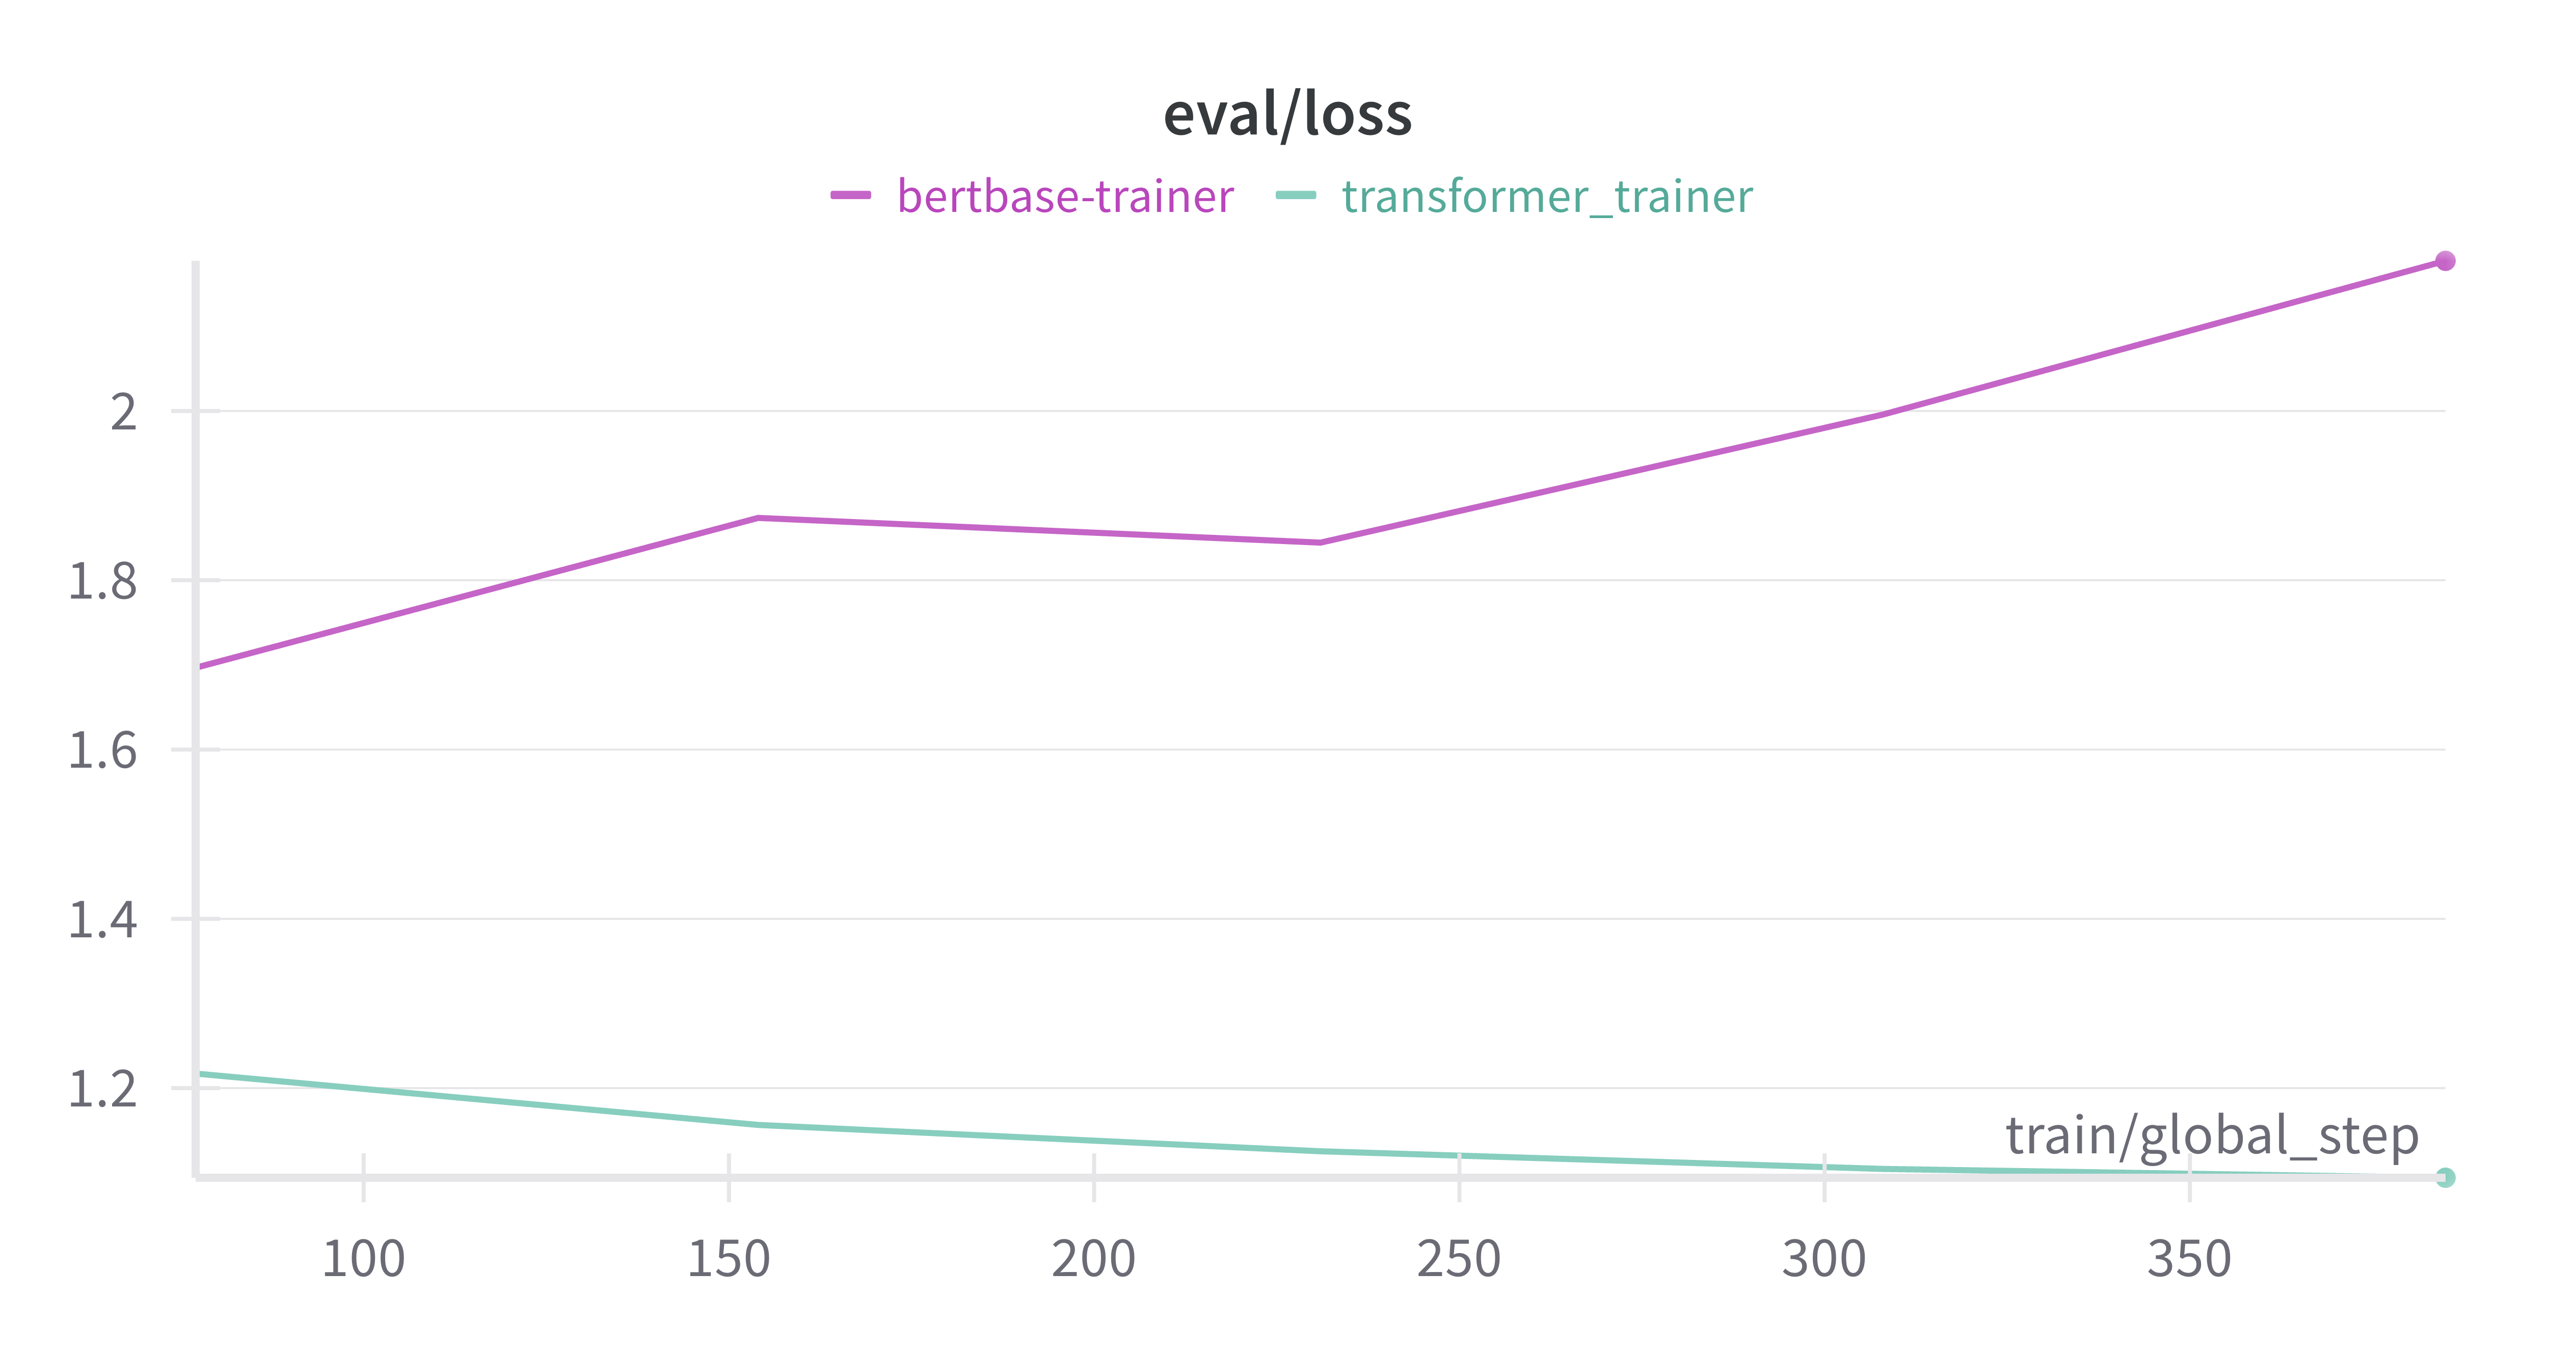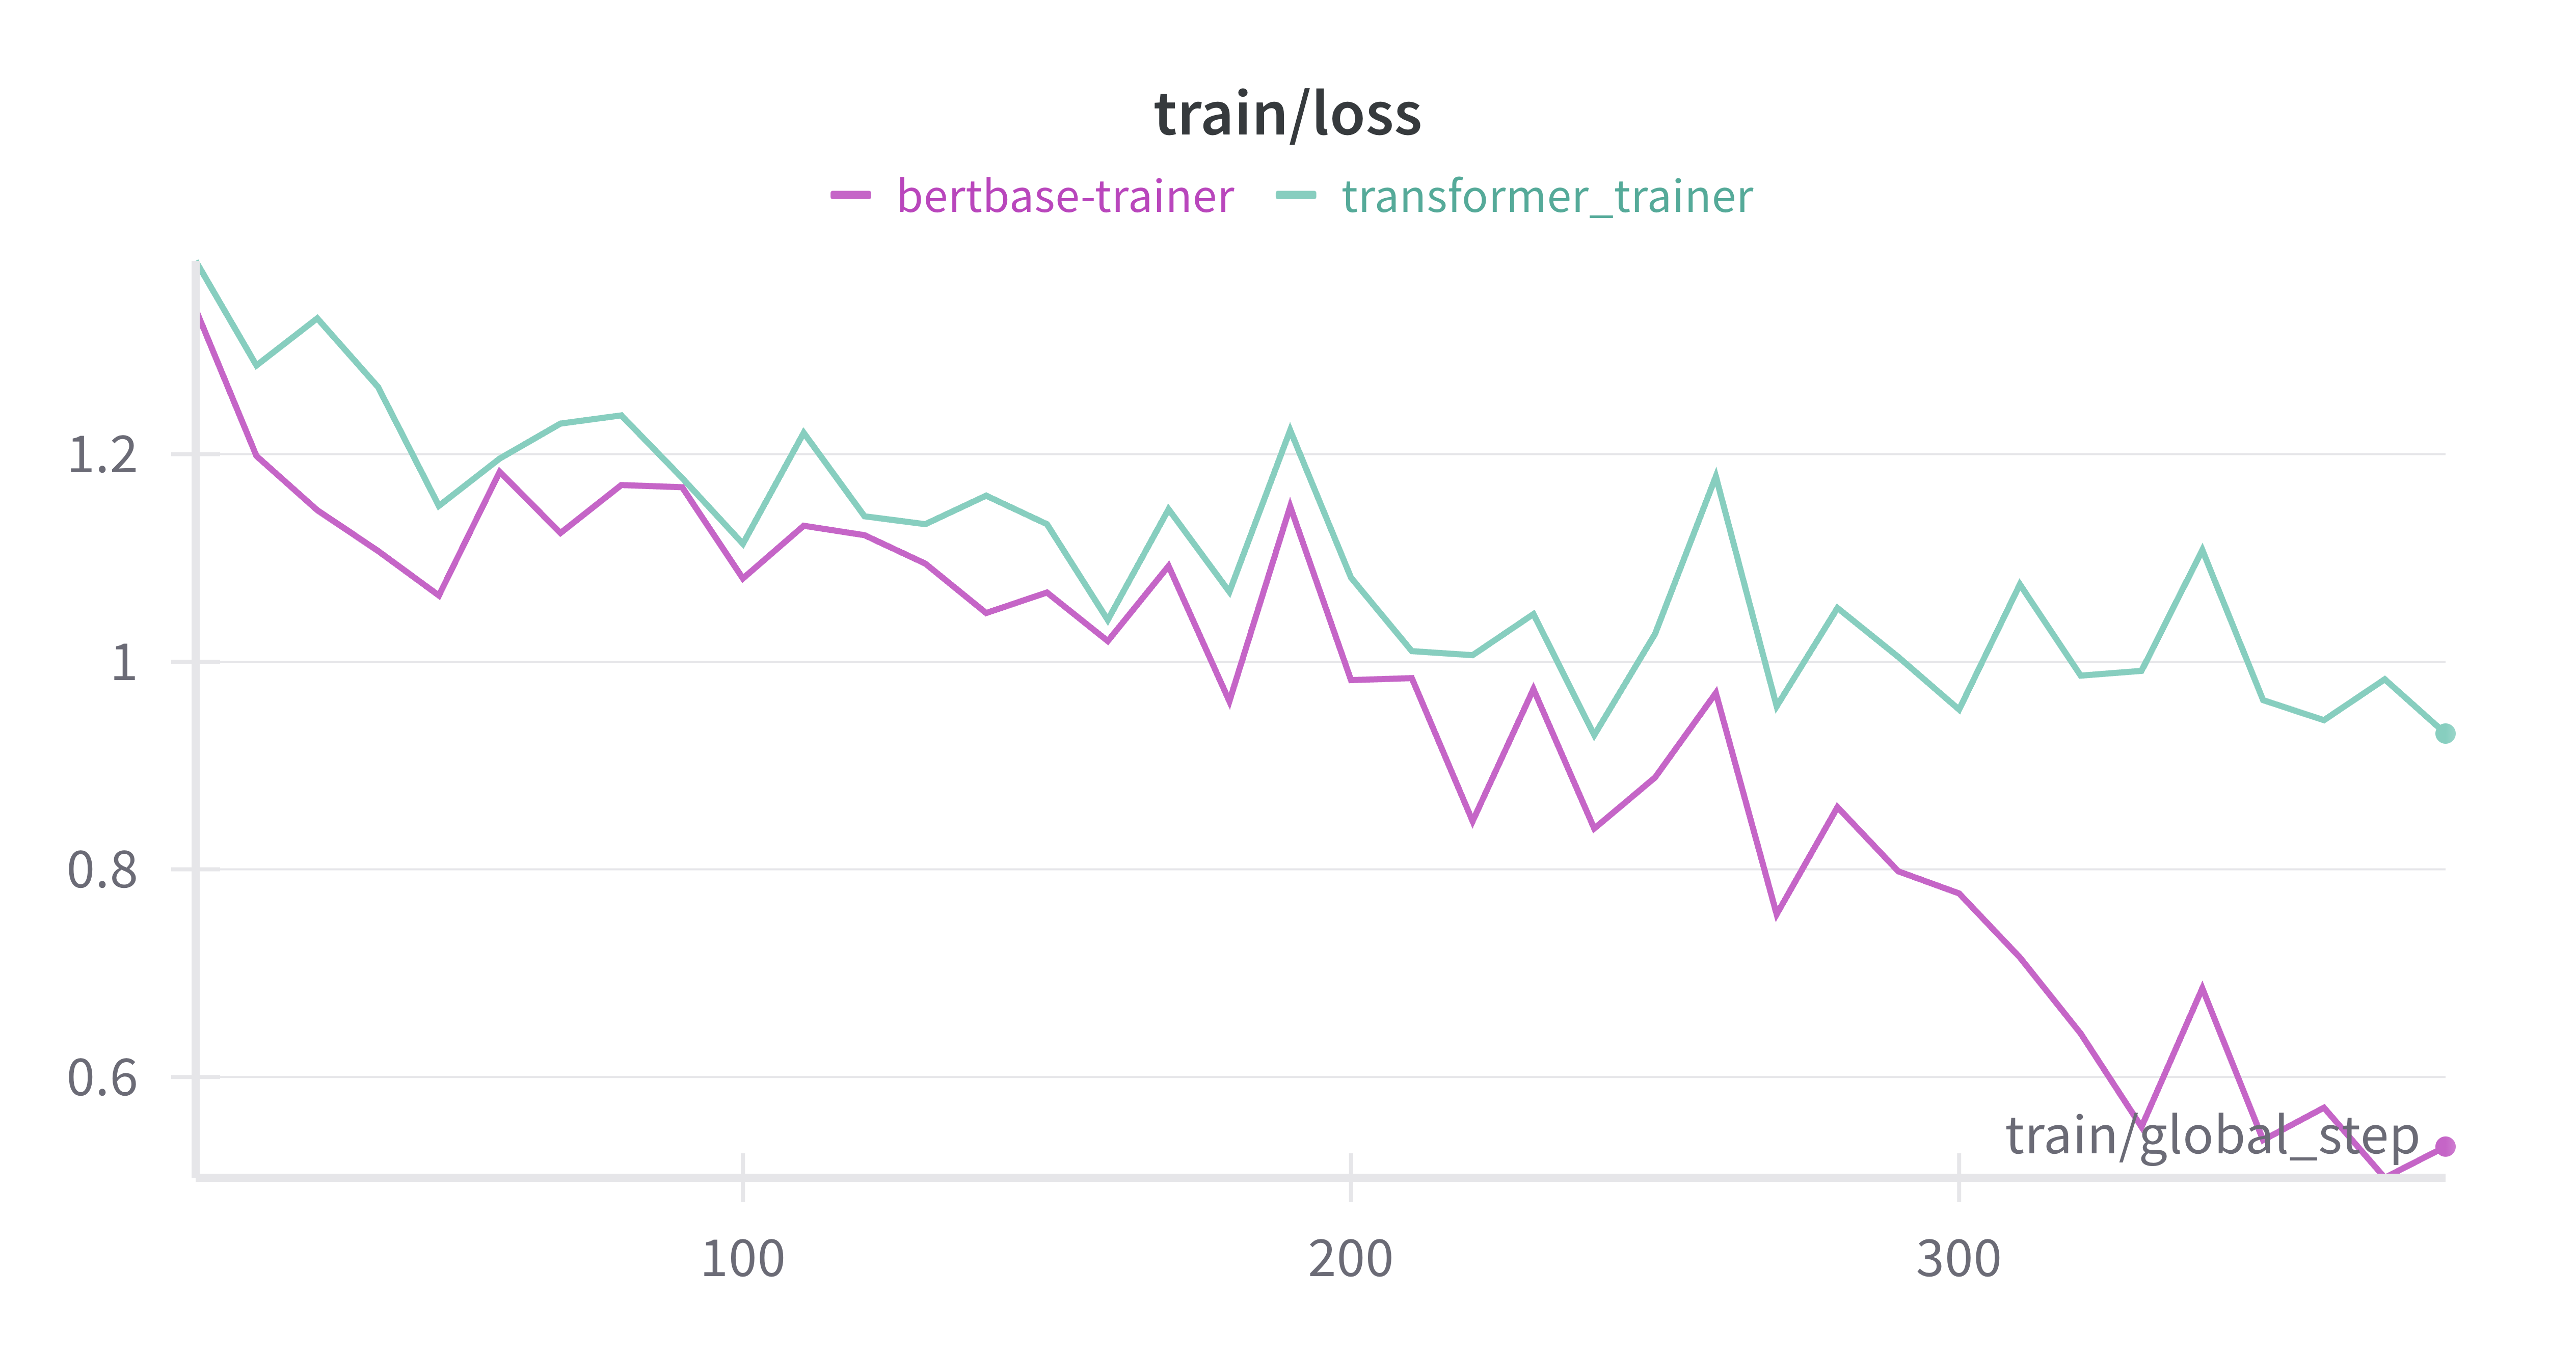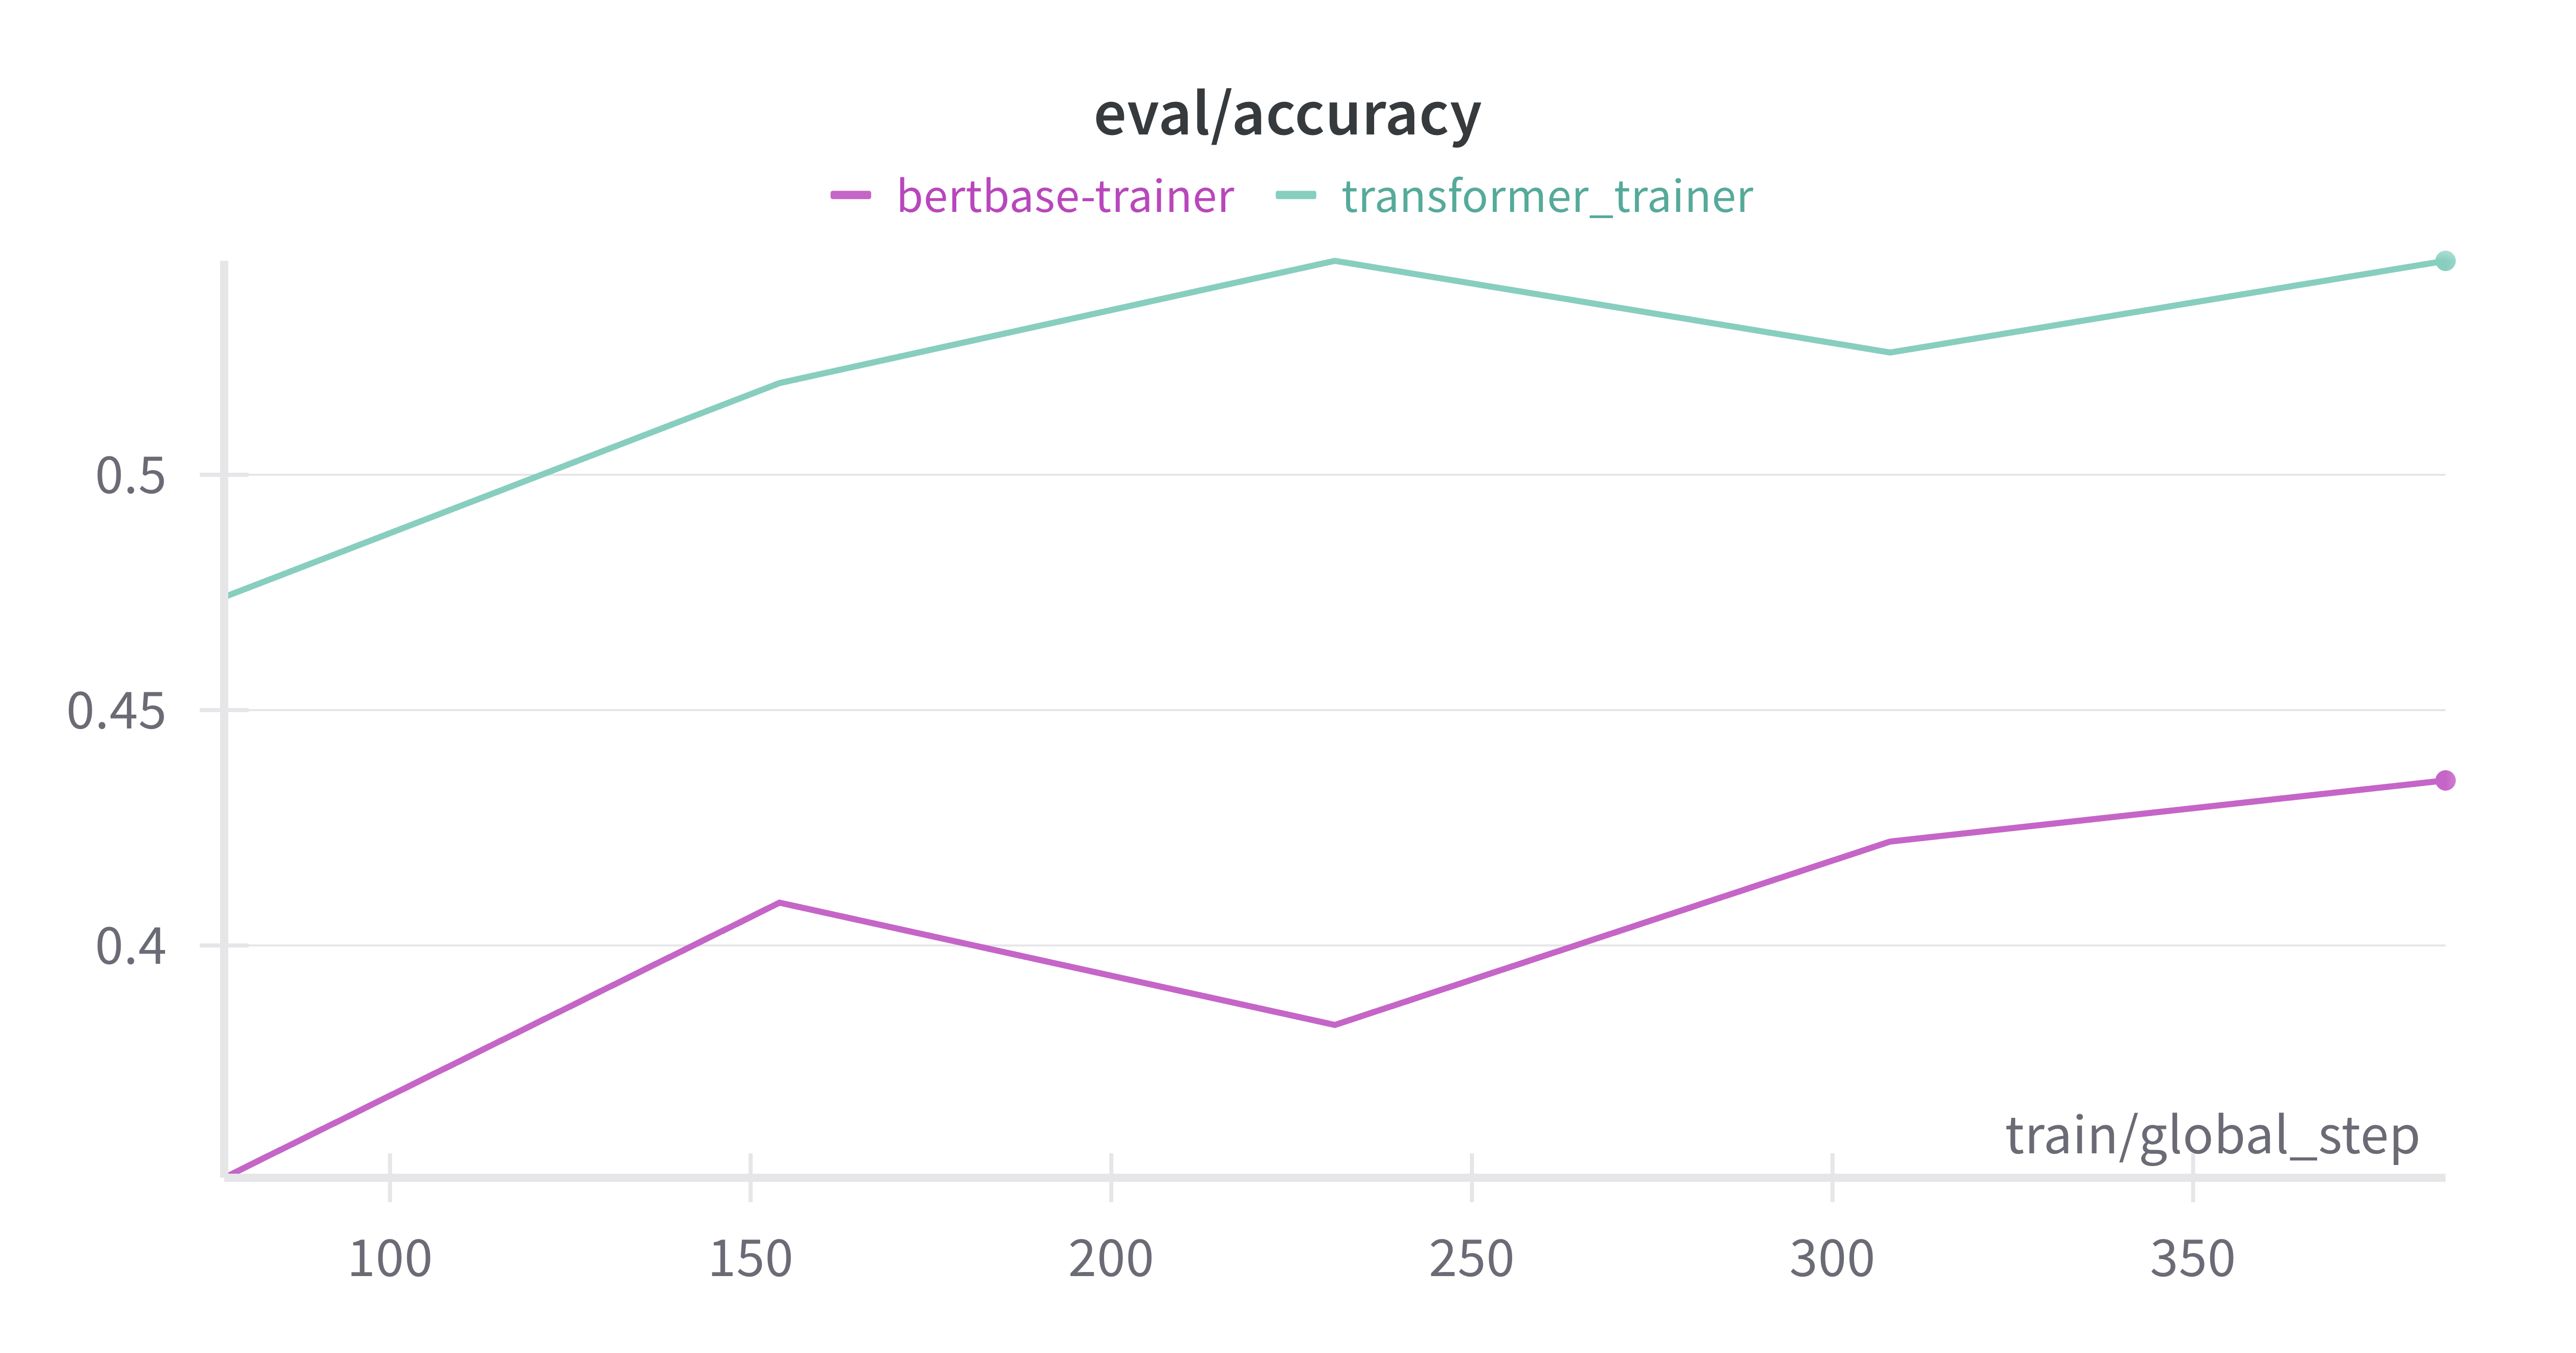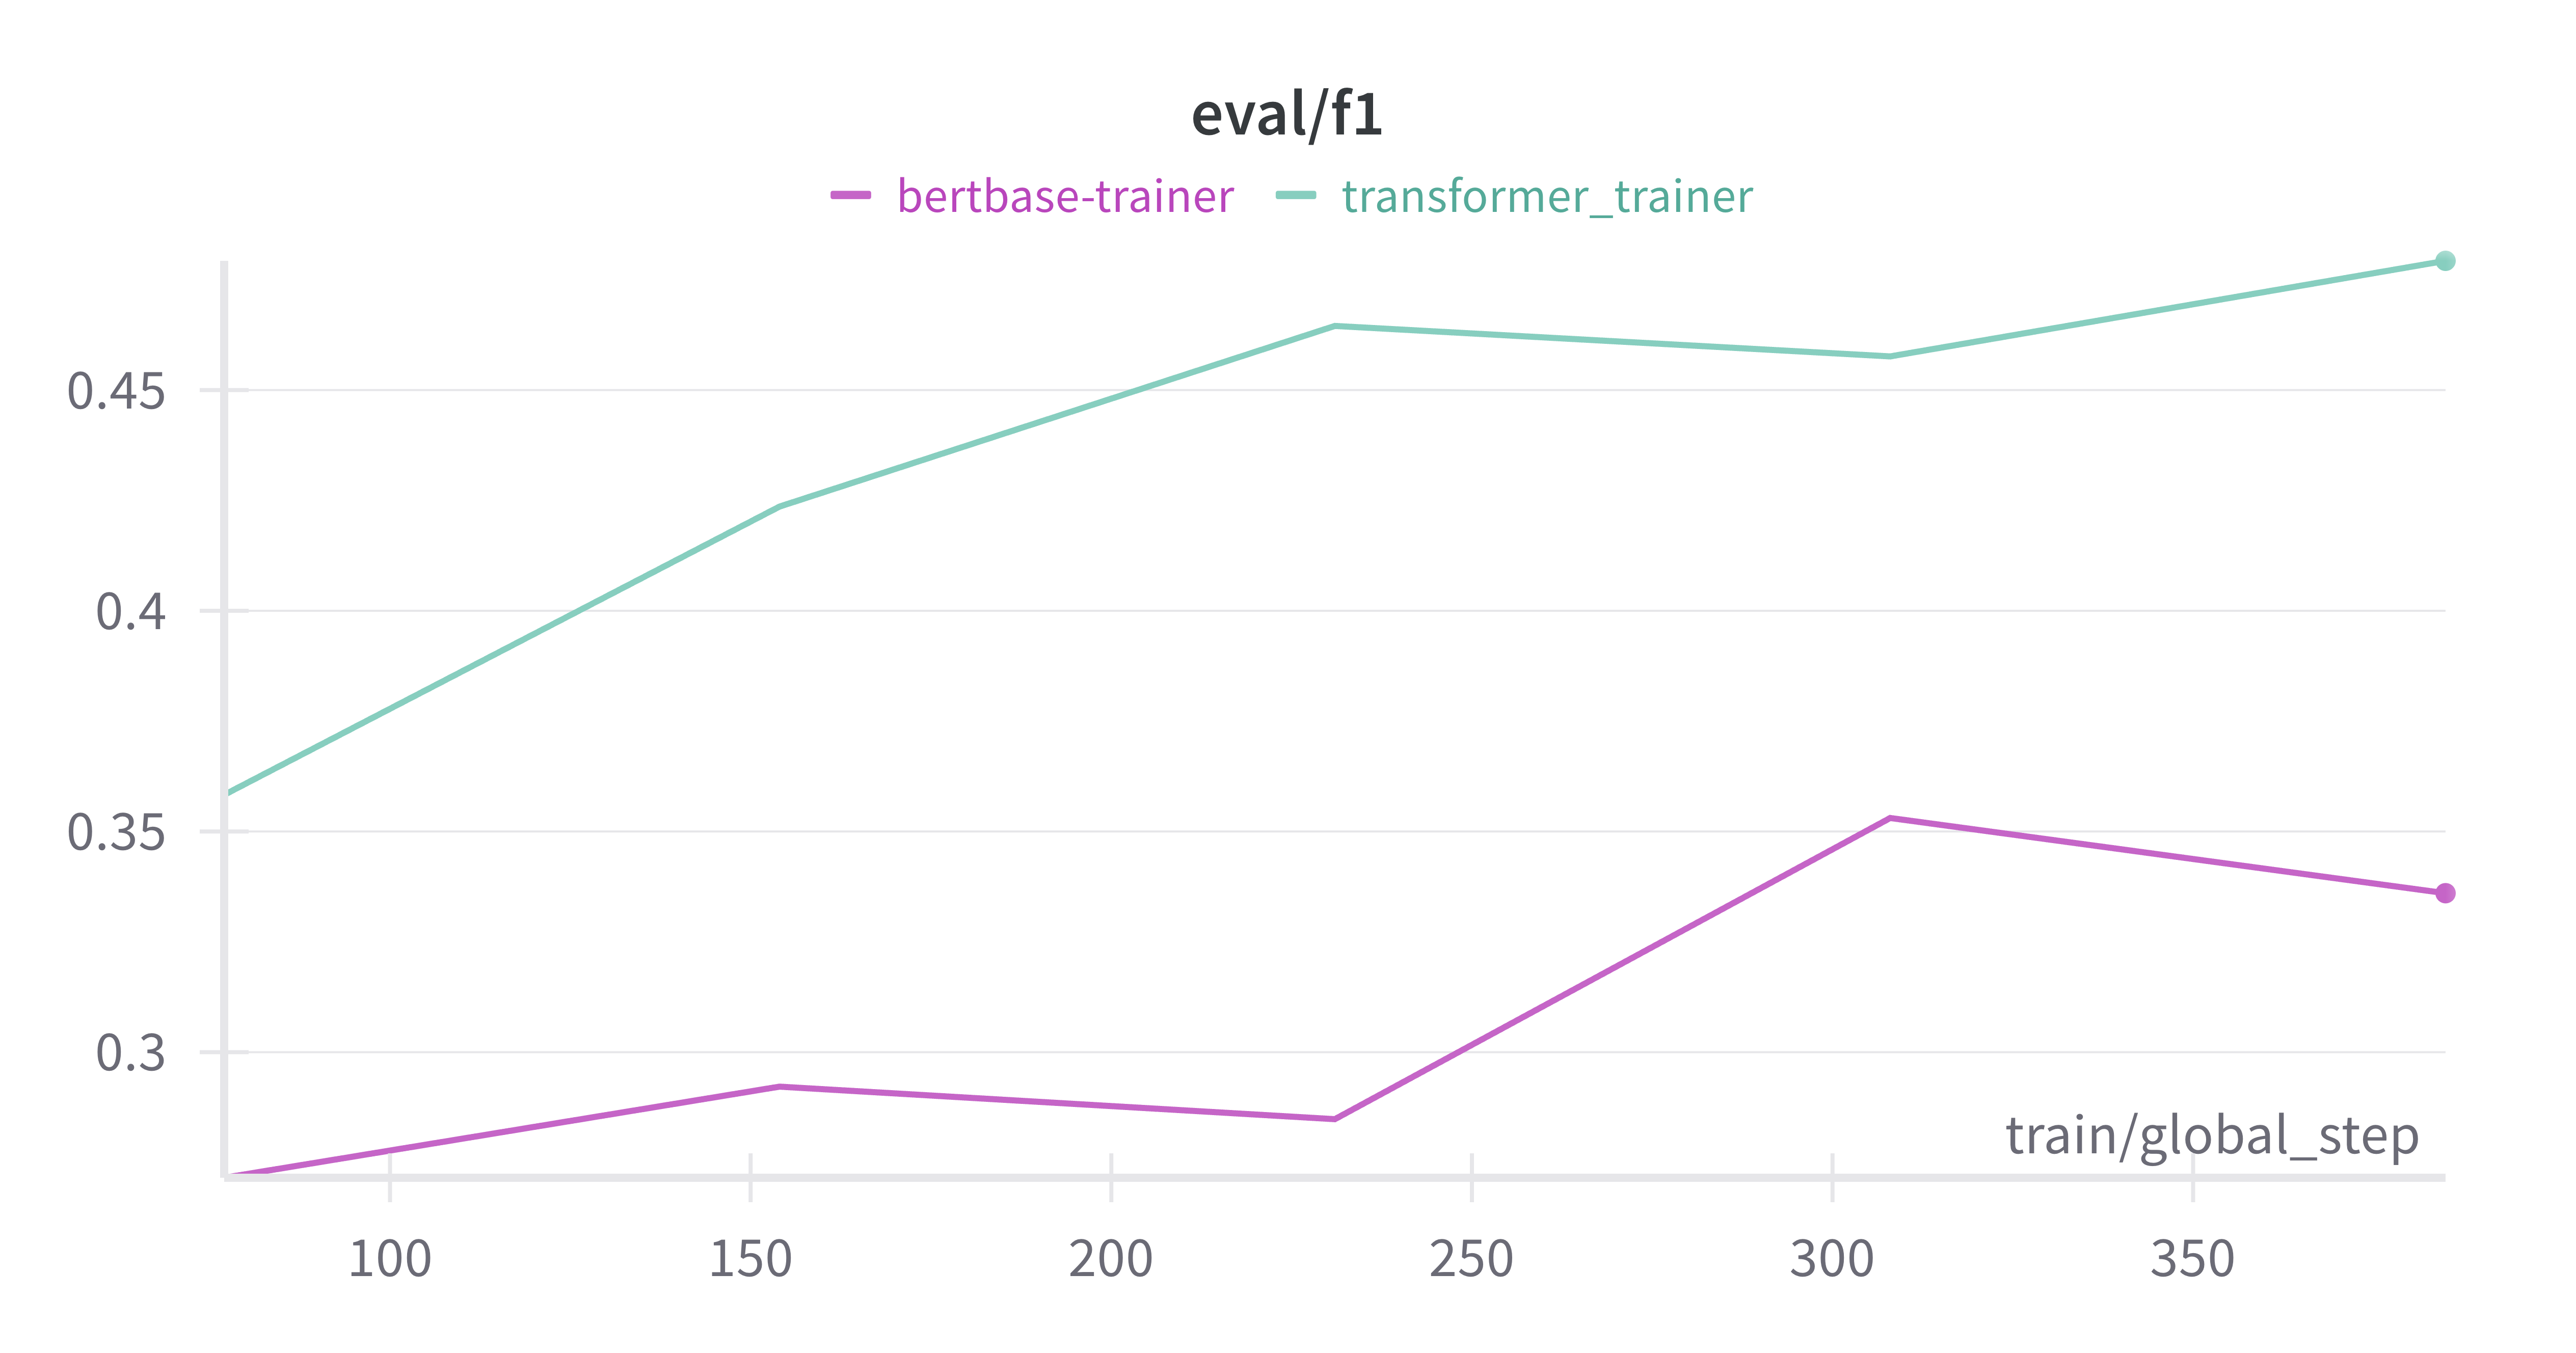

Accuracy and F1 Using eval.py

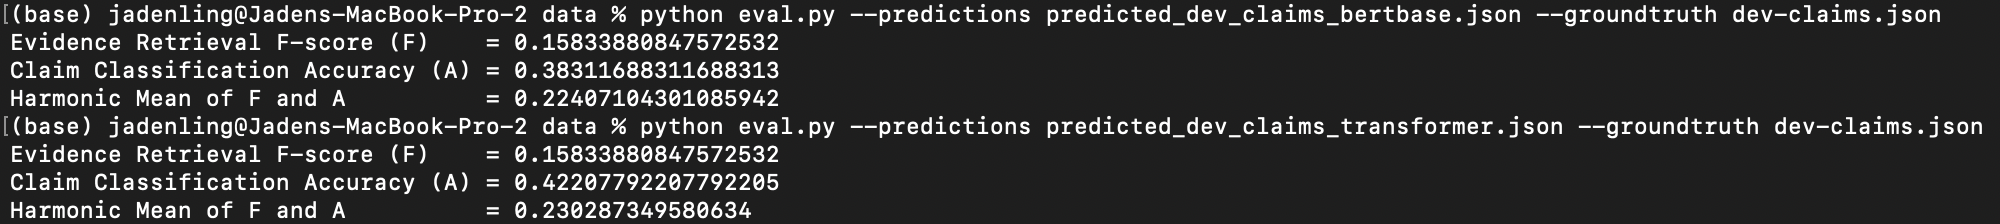

In [73]:
!python /content/COMP90042_2025/eval.py \
  --predictions /content/predicted_dev_claims_bertbase.json \
  --groundtruth /content/COMP90042_2025/data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.14199845497808528
Claim Classification Accuracy (A) = 0.4090909090909091
Harmonic Mean of F and A          = 0.21081980827057564


In [74]:
!python /content/COMP90042_2025/eval.py \
  --predictions /content/predicted_dev_claims_transformer.json \
  --groundtruth /content/COMP90042_2025/data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.14199845497808528
Claim Classification Accuracy (A) = 0.44805194805194803
Harmonic Mean of F and A          = 0.21565169364034678


Confusion Matrices

In [75]:
with open('COMP90042_2025/data/dev-claims.json', 'r') as f:
    ground_truth = json.load(f)

with open('predicted_dev_claims_bertbase.json', 'r') as f:
    predicted_bertbase = json.load(f)

with open('predicted_dev_claims_transformer.json', 'r') as f:
    predicted_transformer = json.load(f)

Bert Model

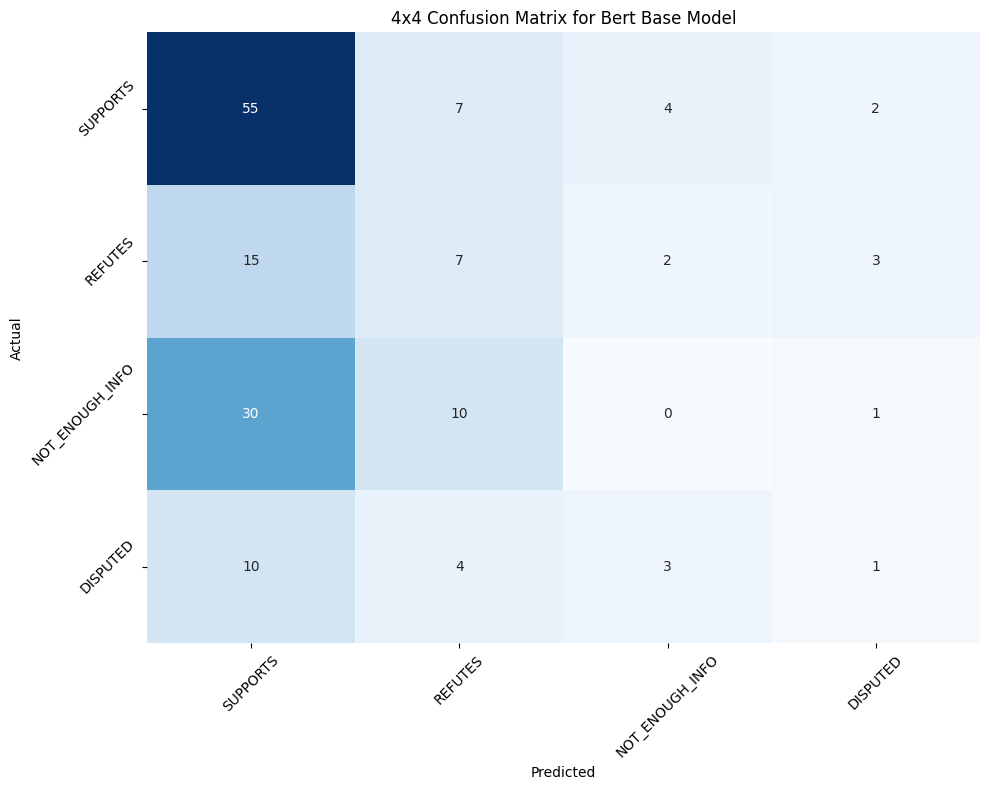

In [76]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# import ace_tools as tools

# Extract the labels
labels = ["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO", "DISPUTED"]
y_true = []
y_pred = []

for claim_id, data in ground_truth.items():
    true_label = data["claim_label"]
    predicted_label = predicted_bertbase.get(claim_id, {}).get("claim_label", None)

    if predicted_label is not None:
        y_true.append(true_label)
        y_pred.append(predicted_label)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Display the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("4x4 Confusion Matrix for Bert Base Model")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the matrix as a DataFrame to the user
# tools.display_dataframe_to_user(cm_df, name="Confusion Matrix - Predictions vs Ground Truth")

In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 Score
f1_macro = f1_score(y_true, y_pred, labels=labels, average='macro')
f1_micro = f1_score(y_true, y_pred, labels=labels, average='micro')
f1_weighted = f1_score(y_true, y_pred, labels=labels, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

F1 Score (Macro): 0.2043
F1 Score (Micro): 0.3831
F1 Score (Weighted): 0.2997


Frozen Transformer

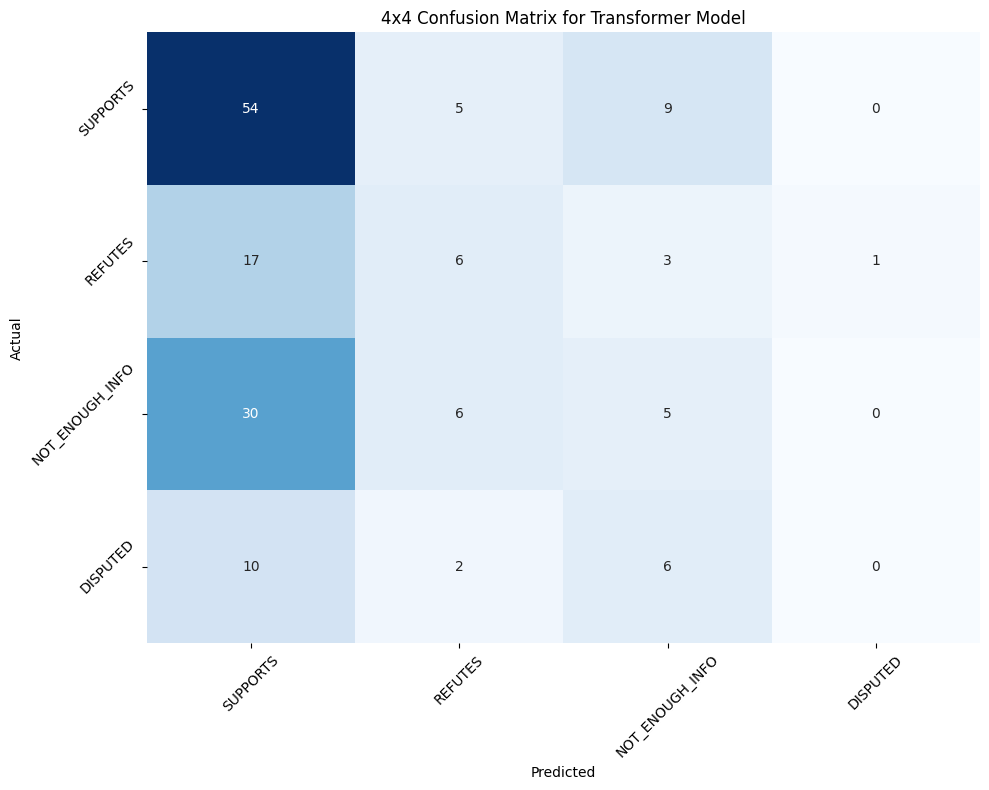

In [ ]:
y_true = []
y_pred = []

for claim_id, data in ground_truth.items():
    true_label = data["claim_label"]
    predicted_label = predicted_transformer.get(claim_id, {}).get("claim_label", None)

    if predicted_label is not None:
        y_true.append(true_label)
        y_pred.append(predicted_label)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Display the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("4x4 Confusion Matrix for Transformer Model")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 Score
f1_macro = f1_score(y_true, y_pred, labels=labels, average='macro')
f1_micro = f1_score(y_true, y_pred, labels=labels, average='micro')
f1_weighted = f1_score(y_true, y_pred, labels=labels, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

F1 Score (Macro): 0.2551
F1 Score (Micro): 0.4221
F1 Score (Weighted): 0.3538


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*